In [48]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.cm as cm
import math
import mat73
from datetime import datetime
import calendar
import allantools as al
import re
from scipy.stats import poisson
from scipy.stats import norm
import gmpy2 as gm

In [49]:
fe3 = 642121496772645.10
fe2 = 688358979309307.82

R_Lange = 0.932829404530965376
R_Lange-0.9328294045309655

-1.1102230246251565e-16

In [50]:
def lineFit(x,m,b):
    return m*x+b
def Gauss(x, A, sig, mu): 
    y = (A/np.sqrt(2*np.pi*sig**2))*np.exp((-(x-mu)**2)/(2.*sig**2)) 
    return y 

def linePts(x, y):
    n = np.size(x)
    fitYs = np.zeros(n)
    param, paramcov = curve_fit(lineFit,x,y, maxfev=5000)
    print(param[0])
    for ii in range(n):
        fitYs[ii] = lineFit(x[ii], param[0], param[1])
    return fitYs

def arbTimetoEpoch(t,t0): #takes t, time elapsed in s since t0 (a date time) and returns epoch time corresponding to t
    return t + t0.timestamp()

def nowToEpoch(time): #takes matlab "now" serial date number in days from Jan 1 0000 and converts to epoch time (s from 1970)
    dec = math.modf(time)[0]
    ing = int(math.modf(time)[1])
    t = datetime.fromordinal(ing-366).timestamp() + dec*24*60*60
    return t

In [51]:
def movingAvg(data, avgPts):
    if avgPts%2 == 1:
        n = np.size(data)
        avgData = np.zeros(n)
        for ii in range(avgPts//2):
            avgData[ii] = np.average(data[:ii+avgPts//2+1])
            avgData[n-1-ii] = np.average(data[n-ii-1-avgPts//2:])
        for ii in range(avgPts//2,n-avgPts//2,1):
            avgData[ii] = np.average(data[ii-avgPts//2:ii+avgPts//2+1])
        return avgData
    else: print("avgPts must be odd")

In [52]:
def importMoku(filename):
    lines=[]
    with open(filename, 'r') as file:
        for line in file:
            lines.append(line)
            #print(line.strip()) 
    lines = lines[10:]
    n = len(lines)
    ts = np.zeros(n)
    f871 = np.zeros(n)
    f933 = np.zeros(n)
    for ii in range(n):
        entries = lines[ii].split(',')
        ts[ii] = float(entries[0])
        f871[ii] = float(entries[2])
        f933[ii] = float(entries[7])

    match = re.search(r"(\d{4})(\d{2})(\d{2})_(\d{2})(\d{2})(\d{2})", filename)
    dt = tuple(map(int, match.groups()))
    print(dt)
    ts = arbTimetoEpoch(ts, datetime(*dt))
    return ts, f871, f933

def importMatlab(filename):
    mat = mat73.loadmat(filename)
    n=int(mat['currentdatapointnr'])
    ni = 30  #-----------cut off points while servo grabs---------------
    ts=mat['aomfrequsmatrix'][ni:n-1,0]
    #print(ts[0])

    for ii in range(np.size(ts)):
        ts[ii] = nowToEpoch(ts[ii])         #times now in epoch time
    fe2aom=mat['aomfrequsmatrix'][ni:n-1,1]
    fe3aom=mat['aomfrequsmatrix'][ni:n-1,4]
    return ts, fe2aom, fe3aom

In [53]:
file1 =  r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\MokuPhasemeterData_20250402_131201.csv"

In [54]:
ts,  f871s, f933s  = importMoku(file1)

(2025, 4, 2, 13, 12, 1)


In [55]:
np.size(ts)

356760

In [56]:
(1.743621121e9 - ts[0])/(60*60)

0.0

1743621121.0


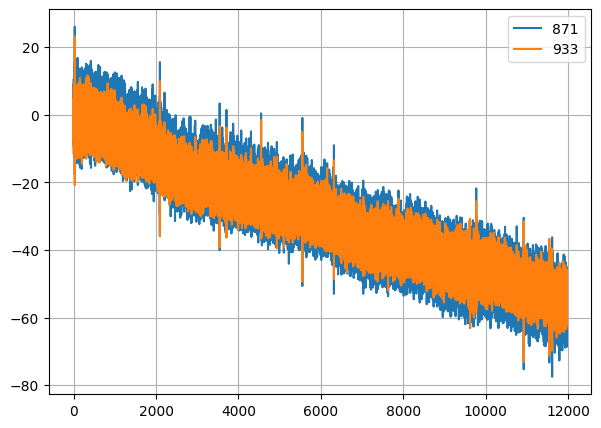

In [57]:
print(ts[0])
#ncut = np.argmin(np.abs(ts-ts[0]-10500))
#f871s = f871s[ncut:]
#f933s = f933s[ncut:]
#ts = ts[ncut:]
plt.figure(figsize=(7,5), dpi = 100)
plt.plot(ts-ts[0], f871s-f871s[0], label="871")
plt.plot(ts-ts[0], f933s-f933s[0], label="933")
plt.legend()
#plt.xlim([0,30000])
plt.grid()
plt.show()

In [58]:
file2 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20250402_1.mat"

In [59]:
taoms, fe2aom, fe3aom  = importMatlab(file2)

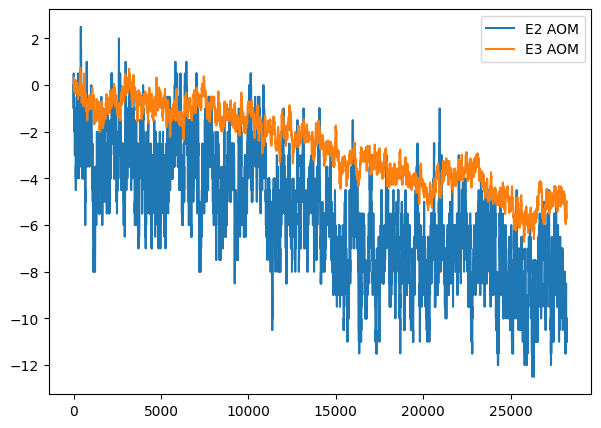

In [60]:
plt.figure(figsize=(7,5), dpi = 100)
plt.plot(taoms-taoms[0], fe2aom-fe2aom[0], label="E2 AOM")
plt.plot(taoms-taoms[0], fe3aom-fe3aom[0], label="E3 AOM")
plt.legend()
plt.show()

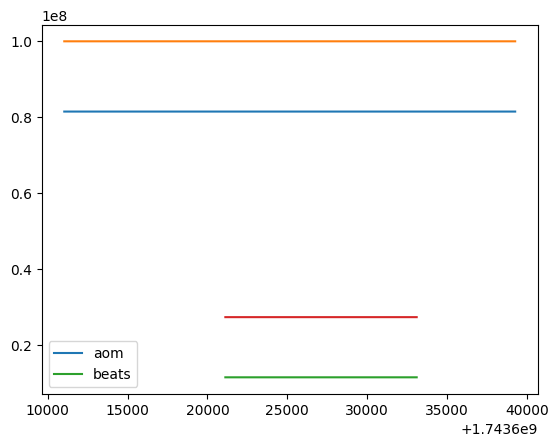

In [61]:
plt.plot(taoms, fe2aom, label="aom")
plt.plot(taoms, fe3aom)
plt.plot(ts, f871s, label="beats")
plt.plot(ts, f933s)
plt.legend()
plt.show()

In [62]:
#--------------------define length of interrogation-------------
tInt = 2.01
#-----------------------------------------------------------
if ts[0]>taoms[0]:
    print("case 1")
    for ii in range(np.size(taoms)):
        if (taoms[ii] - tInt)>ts[0]: 
            ni=ii
            #print(ni)
            break
    taoms = taoms[ni:]
    fe2aom = fe2aom[ni:]
    fe3aom = fe3aom[ni:]
    print(ts[0]-taoms[0])
else:
    print("case 2")
    for ii in range(np.size(ts)):
        if ts[ii]>taoms[0]:
            ni=ii
            print(ni)
            break
    ts = ts[ni:]
    f871s = f871s[ni:]
    f933s = f933s[ni:]
    print(ts[0]-taoms[0])

if ts[-1]>taoms[-1]:
    print("case 1")
    for ii in range(np.size(ts)):
        if ts[ii]>taoms[-1]:
            nf=ii
            break
    ts = ts[:nf]
    f871s = f871s[:nf]
    f933s = f933s[:nf]
    print(ts[-1]-taoms[-1])
else:
    print("case 2")
    for ii in range(np.size(taoms)):
        if taoms[ii]>ts[-1]:
            nf=ii
            break
    taoms = taoms[:nf]
    fe2aom = fe2aom[:nf]
    fe3aom = fe3aom[:nf]
    print(ts[-1]-taoms[-1])

case 1
-2.0440027713775635
case 2
1.7246103286743164


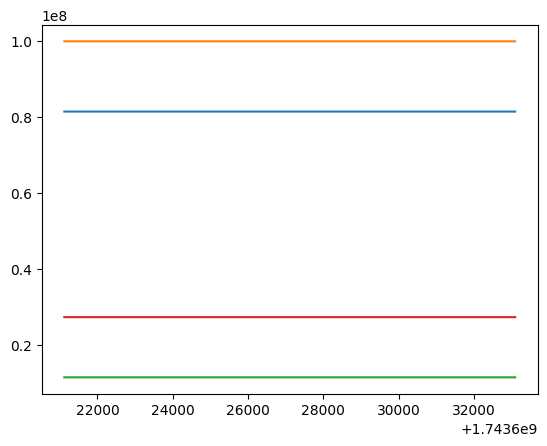

In [63]:
plt.plot(taoms, fe2aom)
plt.plot(taoms, fe3aom)
plt.plot(ts, f871s)
plt.plot(ts, f933s)

In [81]:
n = np.size(taoms)
f871adj = np.zeros(n)
f933adj = np.zeros(n)

ii = 0
n1 = 0 
n2 = 0
#n=10

while ii<n:
    #print(ii)
    while ts[n1] < (taoms[ii]-tInt):
        n1+=1
    #print(ts[n1]-(taoms[ii]-tInt))
    while ts[n2] < taoms[ii]:
        n2 +=1
    #print(ts[n2-1]-taoms[ii])
    #print(n2-1-n1)
    f871adj[ii] = np.average(f871s[n1:(n2-1)])
    f933adj[ii] = np.average(f933s[n1:(n2-1)])
    
    ii+=1



58
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
58
58
59
59
59
59
58
58
58
58
58
59
58
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
58
59
59
58
59
58
58
59
58
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
58
59
59
59
59
59
58
59
59
59
59
59
59
58
59
58
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
58
59
59
59
58
59
58
58
58
59
58
58
59
59
59
58
58
58
59
59
58
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
58
59
58
59
58
5

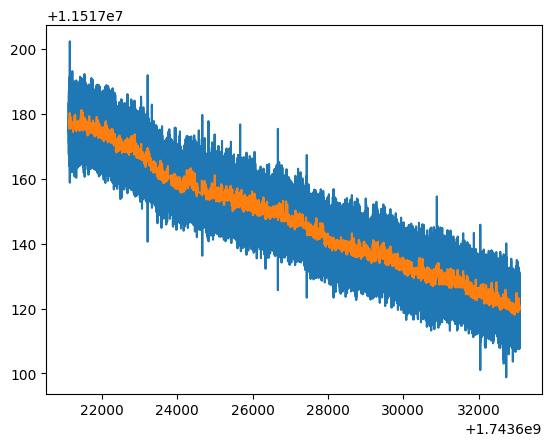

In [66]:
plt.plot(ts, f871s)
plt.plot(taoms, f871adj)

In [67]:
### Must be plus or minus one depending on which side beat note is on
beatSign871 = 1
###-------------------------------------------
frep = 250000066.767
fceo = 70e6
print((fe2/2-fceo + beatSign871*np.average(f871s)+80.0e6+(161.5e6)/2)/frep)
n871 = round((fe2/2-fceo + beatSign871*np.average(f871s)+80.0e6+(161.5e6)/2)/frep)
print(n871)

1376718.0000098816
1376718


In [68]:
### Must be plus or minus one depending on which side beat note is on
beatSign933 = +1
###-----------------------------------------------
print((fe3/2-fceo + beatSign933*np.average(f933s)+80.0e6+100e6/2)/frep)
n933 = round((fe3/2-fceo + beatSign933*np.average(f933s)+80.0e6+100e6/2)/frep)
print(n933)

1284243.000008713
1284243


In [69]:
nuA = fceo - beatSign871*f871adj
nuB = (n871/n933)*(fceo-beatSign933*f933adj)
nuC = nuA - nuB
ratio = nuC/(fe3/2.+130e6)+n871/n933
np.average(ratio) - (fe2+240e6+81.5e6)/(fe3+160e6+100e6)

-4.214406601477094e-13

In [70]:
B = 31.275/(1e-9*0.59930*9.2740100657e-24/6.626e-34) # in mu T
e2Zee = 52.14*B**2*1e-3
e3Zee = -2.082*B**2*1e-3
e2BBR = -517e-18*fe2
e3BBR = -73.6e-18*fe3
e2Quad = 0.049409
e3Quad = -0.049409/92.1

f933 = (fe3/2.+130e6) 
e2Shift = e2Zee+e2BBR+e2Quad
e3Shift = e3Zee+e3BBR+e3Quad
R = (2.*ratio-240e6/f933-fe2aom/f933-e2Shift/f933)/(2-160e6/f933-fe3aom/f933-e3Shift/f933)
print("---Ratio Residual-----")
print((1/np.average(R) - R_Lange))
print(((1/np.average(R) - R_Lange)/R_Lange*fe2), " Hz")
print("---------------------")

---Ratio Residual-----
3.3306690738754696e-16
0.2457786979027299  Hz
---------------------


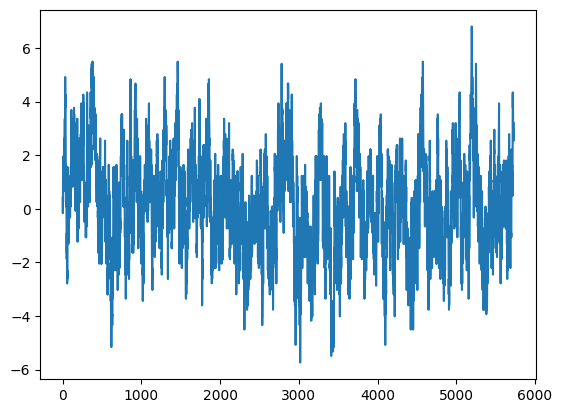

In [79]:
plt.plot((1/R-R_Lange)/R_Lange*fe2)


# Allan Deviation

In [76]:
#tauPts = 40
#taus = np.logspace(-2,3, tauPts)
#adev = np.zeros(tauPts)

rate = 1./(ts[1]-ts[0])

taus,adev,adevErr,_ = al.adev(R,rate, data_type="freq")

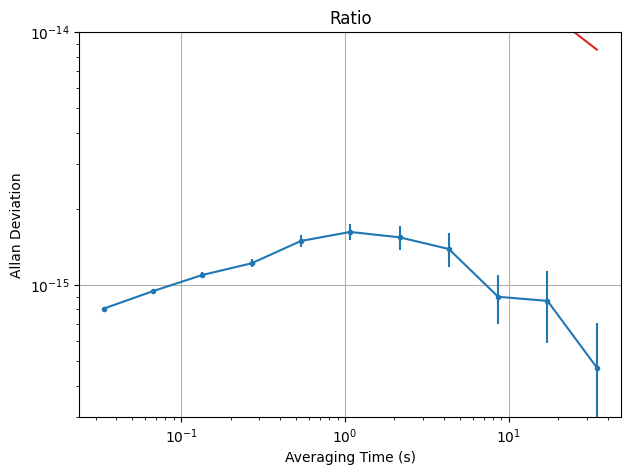

In [77]:
plt.figure(figsize=(7,5), dpi = 100)

plt.errorbar(taus, adev, yerr=adevErr, fmt=".", c="tab:blue")
plt.loglog(taus, adev, label="Ratio", c="tab:blue")
#plt.loglog(taus, 5e-14/np.sqrt(taus), c="tab:red")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Allan Deviation")
plt.xlabel("Averaging Time (s)")
plt.title("Ratio")
plt.ylim([3e-16, 1e-14])
plt.grid()
plt.show()

In [80]:
a = np.array([0,1,2,3,4])
a[0:2]

array([0, 1])